In [1]:
#Importing libraries and loading dataset
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
from datetime import datetime

#Conert into datetime format
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
                          
org_col_names=["No", "year","month", "day", "hour", "pm2.5", "DEWP","TEMP", "PRES", "cbwd", "Iws", "Is", "Ir"]
col_names = ['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow', 'rain']   
                            
dataset = pd.read_csv('AirPollution.csv',index_col=0, date_parser=parse,parse_dates=[['year', 'month', 'day', 'hour']])                            

In [2]:
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [3]:
# Data cleaning
dataset.drop('No', axis=1, inplace=True)
dataset.columns = col_names
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:] # drop the first day
print(dataset.head(5))
dataset.to_csv('pollution.csv') # save new CSV

                     pollution  dew  temp  pressure w_dir  w_speed  snow  rain
year_month_day_hour                                                           
2010-01-02 00:00:00      129.0  -16  -4.0    1020.0    SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0    1020.0    SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0    1021.0    SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0    1022.0    SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0    1022.0    SE     6.25     2     0


In [4]:
# load dataset
df = pd.read_csv('pollution.csv', header=0, index_col=0)
df.describe()

,pollution,dew,temp,pressure,w_speed,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [5]:
dataset_columns = df.columns.tolist()
dataset_columns

['pollution', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow', 'rain']

In [6]:
#Dropping other columns except pollution column
df = df.drop(['dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow', 'rain'],axis = 1)
df.head()

,pollution
year_month_day_hour,
2010-01-02 00:00:00,129.0
2010-01-02 01:00:00,148.0
2010-01-02 02:00:00,159.0
2010-01-02 03:00:00,181.0
2010-01-02 04:00:00,138.0


<AxesSubplot:>

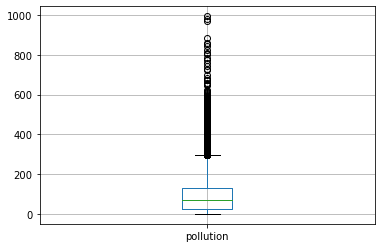

In [7]:
#Box plot
#pd.options.display.mpl_style = False
df.boxplot()

In [8]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [9]:
scaled_dataset[:2,:]

array([[0.12977867],
       [0.14889336]])

In [10]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [11]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)


Y (43796, 1)
X (43796, 4, 1)


In [12]:
#Splitting the dataset
n_train = 24*365
X_train, X_test = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (35036, 4, 1)
X_test (8760, 4, 1)
Y_train (35036, 1)
Y_test (8760, 1)


In [13]:
#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')         

In [14]:
#Train the model
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
1095/1095 [==============================] - 25s 17ms/step - loss: 0.0017
Epoch 2/20
1095/1095 [==============================] - 19s 17ms/step - loss: 8.8612e-04
Epoch 3/20
1095/1095 [==============================] - 19s 17ms/step - loss: 8.5479e-04
Epoch 4/20
1095/1095 [==============================] - 20s 18ms/step - loss: 8.5022e-04
Epoch 5/20
1095/1095 [==============================] - 17s 15ms/step - loss: 8.3740e-04
Epoch 6/20
1095/1095 [==============================] - 15s 13ms/step - loss: 8.4547e-04
Epoch 7/20
1095/1095 [==============================] - 14s 13ms/step - loss: 8.1818e-04
Epoch 8/20
1095/1095 [==============================] - 15s 13ms/step - loss: 8.3381e-04
Epoch 9/20
1095/1095 [==============================] - 15s 14ms/step - loss: 8.3170e-04
Epoch 10/20
1095/1095 [==============================] - 15s 14ms/step - loss: 8.2799e-04
Epoch 11/20
1095/1095 [==============================] - 15s 14ms/step - loss: 8.0467e-04
Epoch 12/20
1095/1095 [

In [15]:
#Taking predictions
Y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_test, Y_pred)

rmse = np.sqrt(mse)
rmse

0.030177719111873485

In [16]:
#Y_predicted = scaler.inverse_transform(Y_pred)
print('y_predicted',Y_pred.shape)
#print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)
print('scaled Values shape', scaled_dataset.shape)

y_predicted (8760, 1)
X_test (8760, 4, 1)
scaled Values shape (43800, 1)


In [17]:
#Scaling back to the original scale
d = scaled_dataset[:8760,:]
print('dummy',d.shape)
print('Y_pred',Y_pred.shape)
Y_predicted = np.concatenate((Y_pred,d[:8760,1:]), axis =1)
print('concat y_pred',Y_pred.shape)
Y_tested = np.concatenate((Y_test, d[:8760,1:]), axis = 1)
print('concat Y_test', Y_test.shape)

dummy (8760, 1)
Y_pred (8760, 1)
concat y_pred (8760, 1)
concat Y_test (8760, 1)


In [18]:
#Take inverse transform
Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)

Y_tested (8760, 1)
Y_predicted (8760, 1)


In [19]:
#Calculate error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_tested, Y_predicted)

rmse = np.sqrt(mse)
rmse

29.99665279720224

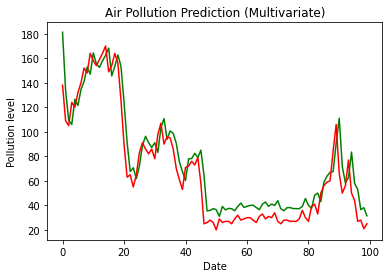

In [20]:
#Plot the graph between actual vs predicted values
plt.plot(Y_predicted[:100,:], color= 'green')
plt.plot(Y_tested[:100,:] , color = 'red')
plt.title("Air Pollution Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.show()

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(Y_tested, Y_predicted)
print('MAPE', mape)

MAPE inf


<ipython-input-21-09b064d08334>:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [22]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_tested, Y_predicted)
#print('Mean squared error', mse)
print('RMSE' , np.sqrt(mse))
print("Mean of Test data ", np.mean(Y_tested))

RMSE 29.99665279720224
Mean of Test data  96.04143835616438
